In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Choropleth, CircleMarker
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load dataset
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')

print(df.shape)
df.head()

(517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
# Variable Description from UCI Machine Learning Repository
# X: x-axis spatial coordinate within the Montesinho park map: 1 to 9
# Y: y-axis spatial coordinate within the Montesinho park map: 2 to 9
# month: month of the year: 'jan' to 'dec'
# day: day of the week: 'mon' to 'sun'
# FFMC: FFMC index from the FWI system: 18.7 to 96.20
# DMC: DMC index from the FWI system: 1.1 to 291.3
# DC: DC index from the FWI system: 7.9 to 860.6
# ISI: ISI index from the FWI system: 0.0 to 56.10
# temp: temperature: 2.2 to 33.30 C
# RH: 	relative humidity: 15.0 to 100%

In [4]:
# Check for nulls
print(df.isnull().sum())

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64


In [5]:
print(df.describe())

                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain         area  
count  517.000000  517.000000  517.000000  517.000000   517.000000  
mean    18.889168   44.288201    4.017602    0.021663    12.847292  
std      5.806625   16.317469    1.791653    0.295959    63.655

In [6]:
# Convert 'area' to binary classification target: Fire vs no Fire
df['fire_occurred'] = (df['area'] > 0).astype(int)


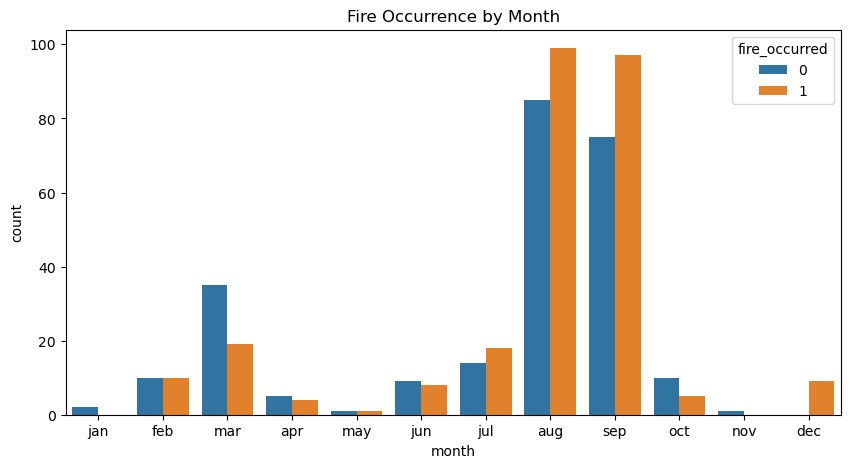

In [7]:
# Visualize fire occurrence by month
plt.figure(figsize=(10,5))
sns.countplot(x='month', hue='fire_occurred', data=df, order=[
              'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
plt.title("Fire Occurrence by Month")
plt.show()

In [8]:
# Fires occur most in August and September

In [11]:
# Filter fires with burned area > 0
fires = df[df['area'] > 0]

In [12]:
# X and Y coordinates in data set are not real longitude and latitude coordinates (spatial coordinate within the Montesinho park map)
# Google search shows coordinates for Montesinho park are (lat = 41.9062, lon = -8.8600)
# Scale dataset's x,y coordinates to lat, long
fires['lat'] = 41.9062 + (fires['Y'] * 0.01)
fires['lon'] = -8.8600 + (fires['X'] * 0.01)

C:\Users\travi\AppData\Local\Temp\ipykernel_22892\682411134.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fires['lat'] = 41.9062 + (fires['Y'] * 0.01)
C:\Users\travi\AppData\Local\Temp\ipykernel_22892\682411134.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fires['lon'] = -8.8600 + (fires['X'] * 0.01)


In [13]:
#create new DataFrame to avoid pandas error warning above
fires = df[df['area'] > 0].copy()

fires['lat'] = 41.9062 + (fires['Y'] * 0.01)
fires['lon'] = -8.8600 + (fires['X'] * 0.01)

In [18]:
# Create folium map centered near the area
m = folium.Map(location=[41.91, -8.86], zoom_start=13, tiles='CartoDB positron')

In [19]:
heat_data = fires[['lat', 'lon', 'area']].values.tolist()
HeatMap(heat_data).add_to(m)

In [20]:
m

In [21]:
m.save('fire_heatmap.html')

In [24]:
df_model = df.copy()

# Encode month and day
label_enc = LabelEncoder()
df_model['month'] = label_enc.fit_transform(df_model['month'])
df_model['day'] = label_enc.fit_transform(df_model['day'])

In [25]:
# Define features and target
features = ['X', 'Y', 'month', 'day', 'temp', 'RH', 'wind', 'rain']
X = df_model[features]
y = df_model['fire_occurred']

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [28]:
# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.53      0.56        77
           1       0.59      0.65      0.61        79

    accuracy                           0.59       156
   macro avg       0.59      0.59      0.59       156
weighted avg       0.59      0.59      0.59       156



In [29]:
# Predict fire probability
df_model['fire_risk_score'] = model.predict_proba(X)[:, 1]  # 0 = no fire, 1 = fire

# Add lat/lon for mapping (same as before)
df_model['lat'] = 41.9062 + (df_model['Y'] * 0.01)
df_model['lon'] = -8.8600 + (df_model['X'] * 0.01)

In [30]:
# Create map, using CartoDB positron for light gray background, standard for GIS 
risk_map = folium.Map(location=[41.91, -8.86], zoom_start=13, tiles='CartoDB positron')

# Normalize risk to 0–1 range (for color)
for _, row in df_model.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        fill=True,
        fill_color='red' if row['fire_risk_score'] > 0.5 else 'orange',
        color=None,
        fill_opacity=row['fire_risk_score'],  # higher opacity = more risk
        popup=f"Risk: {row['fire_risk_score']:.2f}"
    ).add_to(risk_map)

In [31]:
risk_map

In [32]:
risk_map.save('fire_risk_map.html')

In [33]:
#Now we have a scored risk map ready for use